In [2]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub

<Axes: title={'center': 'Loss over epochs'}, xlabel='Epoch', ylabel='Mean Squared Error'>

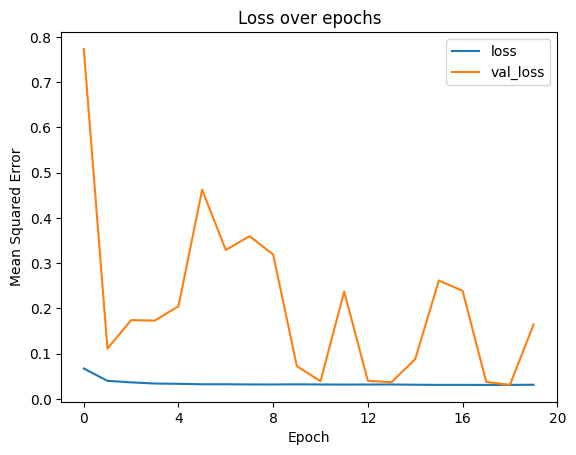

In [2]:
hist_full_2 = pd.read_csv(r"models\full_test_2_history.csv", index_col=0)
hist_full_2.plot(title = "Loss over epochs", ylabel="Mean Squared Error", xlabel="Epoch", xticks=list(range(21)[::4]))

In [3]:
INPUT_IMAGES_DIR = "intermediate_data/patched_data/" 
DUMMY_IMAGE_FEATURES_DIR = "intermediate_data/batch_extracted_image_adatas"
ENRICHMENTS_DIR = "intermediate_data/enrichments_on_updn_de"



In [4]:
# Model setup
IMAGE_SHAPE = (380, 380, 3)
PRETRAINED_HANDLE = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b4-feature-vector/1"
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")


ACTIVATION_FUNC = 'relu'
LEARNING_RATE = 1e-4
EPOCHS = 2
LOAD_MODEL = False



# - Model layers
input_layer = tf.keras.Input(IMAGE_SHAPE)
pretrained_layer = hub.KerasLayer(PRETRAINED_HANDLE, trainable=True)
dense_out_layer = tf.keras.layers.Dense(
    units= 30, #enrichments.shape[1],
    activation=ACTIVATION_FUNC
)
# - Model architecture
model = tf.keras.Sequential([
    input_layer,
    pretrained_layer,
    dense_out_layer
])

# - Compile Model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
              loss = tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanAbsolutePercentageError()]
              )
checkpoint_filepath = f"./intermediate_data/ckpts/checkpoint.weights.h5"


GPU is available


GPU is available


In [5]:
# Load in the dataset
# from model_architecture import dataset_from_spot_names
from linear_model_prediction import get_data_as_dfs
NONNORMALIZED = True
HOLDOUT_BIOPSIES = []
# Get enrichments and class info
_, enrichments, spot_info = get_data_as_dfs(im_features_dir=DUMMY_IMAGE_FEATURES_DIR, enrichments_dir=ENRICHMENTS_DIR,
                                            nonnormalized=NONNORMALIZED)
# Remove biopsies that have been designated as holdouts
for biop in HOLDOUT_BIOPSIES:
    enrichments = enrichments.filter(regex=f"^\w*-1_\d\d\D_(?!{biop})", axis=0)
# Get spot names for dataset making
spot_names = list(enrichments.index)


# Train test split spots
if NONNORMALIZED:
    sd_nn_enrichments = enrichments.std(axis=0)
    mean_nn_enrichments = enrichments.mean(axis=0)
    enrichments = enrichments.sub(mean_nn_enrichments, axis=1).div(mean_nn_enrichments, axis = 1)

spot_suffixes = ["_" + x.split("_")[-1] for x in spot_names]


In [6]:

enrichments_df = enrichments

from image_extracter import image_extracter
helper_extracter = image_extracter()

folder_w_barcode = [f"{INPUT_IMAGES_DIR}*{x.split('_')[-2][:-1]}_{x.split('_')[-2][-1]}*/patches/*{x.split('_')[0]}*" 
                        for x in spot_names]
image_set = helper_extracter.image_set_from_path(folder_w_barcode, 
                                                in_place = False, 
                                                name_append = spot_suffixes) # until spot naming is repaired
images = image_set['images']

# enrichments_dataset = tf.data.Dataset.from_tensor_slices(enrichments_df.loc[spot_names, :])


GPU is available


In [8]:
images.save("intermediate_data/predicted_enrichments_on_updn_de/images_trained_on")

In [7]:
predicted_enrichments = model.predict(images, use_multiprocessing=True)

31404/31404 [==============================] - 270s 8ms/step


In [12]:
predicted_enrichments_df = pd.DataFrame(
    data = predicted_enrichments,
    index = enrichments.index,
    columns = enrichments.columns
)
predicted_enrichments_df.to_csv("intermediate_data/predicted_enrichments_on_updn_de/predicted_enrichments.csv")